<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/04-advanced-ML/HW/hw2/XGBoost_tuning_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost tuning

Будем работать с данными - http://datahack.analyticsvidhya.com/contest/data-hackathon-3x.
Мы решаем задачу классификации на два класса. Сразу будем работать с обработанными и уменьшенными данными (для ускорения процесса обучения). Процесс обработки данных и полный и подробный туториал для данной задачи приведён здесь: https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example. 

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 9

# Загружаем данные

Вы можете работать с train_medium/test_medium, если готовы немного подождать при обучении xgboost. Если вы хотите быстрых результатов, то работайте с файлами train_small/test_small.

In [4]:
X_train = pd.read_csv('https://raw.githubusercontent.com/rklepov/hse-cs-ml-2018-2019/master/04-advanced-ML/03-boosting/train_medium.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/rklepov/hse-cs-ml-2018-2019/master/04-advanced-ML/03-boosting/test_medium.csv')
# X_train = pd.read_csv('https://raw.githubusercontent.com/rklepov/hse-cs-ml-2018-2019/master/04-advanced-ML/03-boosting/train_small.csv')
# X_test = pd.read_csv('https://raw.githubusercontent.com/rklepov/hse-cs-ml-2018-2019/master/04-advanced-ML/03-boosting/test_small.csv')
len(X_train), len(X_test)

(65265, 21755)

In [0]:
target='Disbursed'
IDcol = 'ID'

random_seed=199
cv_folds = 5

In [6]:
X_train['Disbursed'].value_counts(), len(X_train)

(0.0    64316
 1.0      949
 Name: Disbursed, dtype: int64, 65265)

## Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [0]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Начинаем последовательный подбор параметров при большом learning_rate

In [8]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        objective='binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=random_seed)

xgb1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=199,
       silent=True, subsample=1)


Model Report
Accuracy : 0.9855
AUC Score (Train): 0.870066
AUC Score (Test): 0.836413
CPU times: user 1min 41s, sys: 446 ms, total: 1min 42s
Wall time: 59.3 s


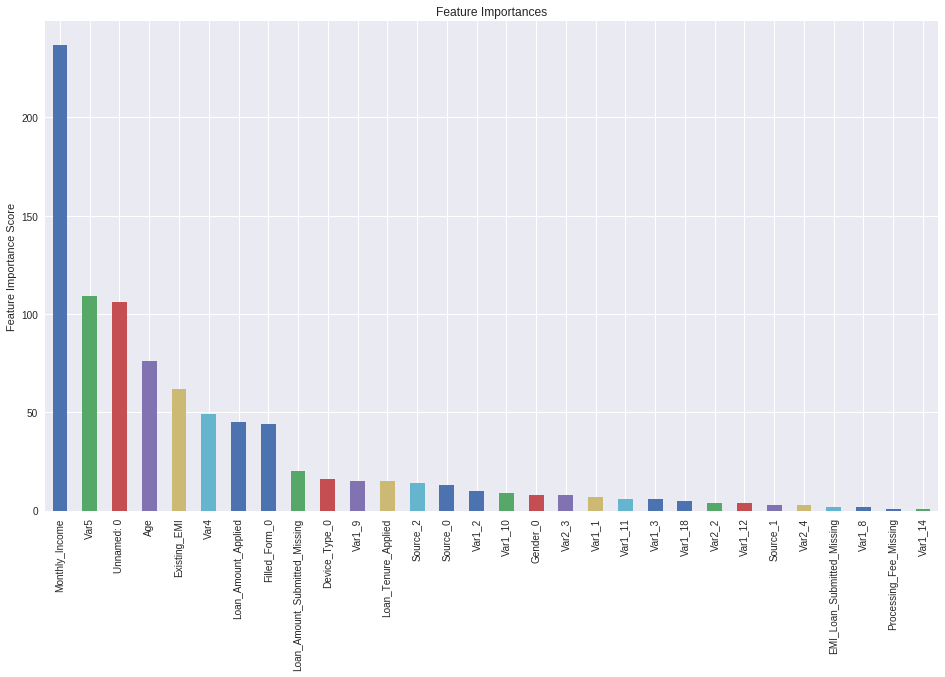

In [9]:
%%time

modelfit(xgb1, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [10]:
%%time

param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=150,
                                        objective='binary:logistic', 
                                        nthread=-1, 
                                        scale_pos_weight=1, 
                                        seed=random_seed),
                        
                        param_grid=param_test1, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch1.fit(X_train[predictors], X_train[target])

CPU times: user 15.4 s, sys: 148 ms, total: 15.5 s
Wall time: 15min 29s


In [11]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8362237271210141)


Уточняем предсказание

In [12]:
%%time

param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[1,2,3,4]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1, 
                                        n_estimators=150, 
                                        objective= 'binary:logistic', 
                                        nthread=-1, 
                                        scale_pos_weight=1,
                                        seed=random_seed),
                        
                        param_grid=param_test2, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch2.fit(X_train[predictors], X_train[target])

CPU times: user 19.1 s, sys: 98.1 ms, total: 19.2 s
Wall time: 8min 22s


In [13]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 2}, 0.8373936820919434)

Зафиксируем найденный max_depth и подберем min_child_weight

In [14]:
%%time

param_test2b = {
    'min_child_weight':range(1,8)
}

gsearch2b = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1, 
                                        n_estimators=150,
                                        max_depth=gsearch2.best_params_['max_depth'],
                                        objective='binary:logistic', 
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=random_seed),
                         param_grid=param_test2b, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch2b.fit(X_train[predictors], X_train[target])

CPU times: user 19.3 s, sys: 78.8 ms, total: 19.4 s
Wall time: 6min 24s


In [15]:
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 7}, 0.8383048763885341)

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma.

In [16]:
%%time

param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

#Your code here

gsearch3 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1, 
                                        n_estimators=150,
                                        max_depth=gsearch2.best_params_['max_depth'],
                                        min_child_weight=gsearch2b.best_params_['min_child_weight'],
                                        objective='binary:logistic', 
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=random_seed),
                        
                         param_grid=param_test3, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch3.fit(X_train[predictors], X_train[target])

CPU times: user 19.2 s, sys: 55.6 ms, total: 19.3 s
Wall time: 4min 43s


In [17]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.1}, 0.8388332472627151)

Установите в качестве параметров алгоритма подобранные max_depth, min_child_weight и gamma и посмотрите как изменилось качество.

In [18]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=150,
        max_depth=gsearch2.best_params_['max_depth'],
        min_child_weight=gsearch2b.best_params_['min_child_weight'],
        gamma=gsearch3.best_params_['gamma'],
        objective='binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=random_seed)

xgb2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=7, missing=None, n_estimators=150,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=199,
       silent=True, subsample=1)


Model Report
Accuracy : 0.9855
AUC Score (Train): 0.888830
AUC Score (Test): 0.832764
CPU times: user 1min 44s, sys: 329 ms, total: 1min 44s
Wall time: 1min 44s


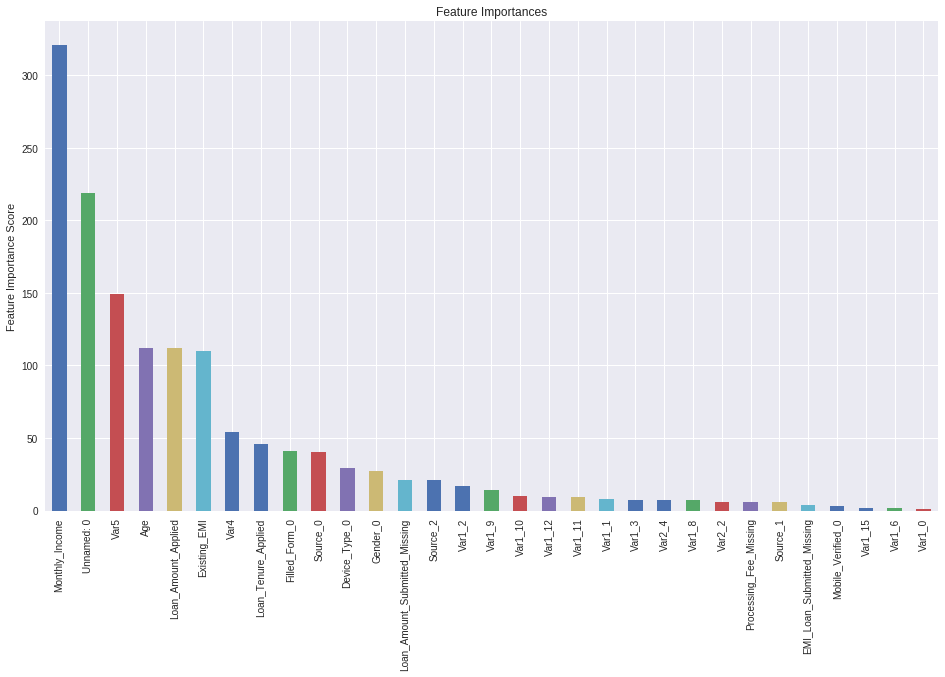

In [19]:
%%time

modelfit(xgb2, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [20]:
%%time

#Your code here

param_test4 = {
    'subsample':[0.6,0.7,0.8,0.9,1.],
    'colsample_bytree':[0.6,0.7,0.8,0.9,1.]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate =0.1,
                                        n_estimators=150,
                                        max_depth=gsearch2.best_params_['max_depth'],
                                        min_child_weight=gsearch2b.best_params_['min_child_weight'],
                                        gamma=gsearch3.best_params_['gamma'],
                                        objective='binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=random_seed),
                        
                         param_grid=param_test4, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch4.fit(X_train[predictors], X_train[target])

CPU times: user 21.4 s, sys: 115 ms, total: 21.5 s
Wall time: 21min 2s


In [21]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 1.0, 'subsample': 0.9}, 0.8391540318688909)

Уточните значения subsample и colsample_bytree. Например, если оптимальный subsample на предыдущем шаге равен 0.6, то теперь перебирайте subsample в диапазоне [0.55,0.6,0.65,0.7]. Аналогично с colsample_bytree.

In [22]:
%%time

#Your code here

param_test4b = {
    'subsample':np.linspace(0.8, 1, 5),
    'colsample_bytree':np.linspace(0.9, 1, 3),
}

gsearch4b = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate =0.1,
                                        n_estimators=150,
                                        max_depth=gsearch2.best_params_['max_depth'],
                                        min_child_weight=gsearch2b.best_params_['min_child_weight'],
                                        gamma=gsearch3.best_params_['gamma'],
                                        objective='binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=random_seed),
                         
                         param_grid=param_test4b, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch4b.fit(X_train[predictors], X_train[target])

CPU times: user 20.9 s, sys: 172 ms, total: 21.1 s
Wall time: 13min 46s


In [23]:
gsearch4b.best_params_, gsearch4b.best_score_

({'colsample_bytree': 1.0, 'subsample': 0.9}, 0.8391540318688909)

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [24]:
%%time

#Your code here

param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate =0.1,
                                        n_estimators=150,
                                        max_depth=gsearch2.best_params_['max_depth'],
                                        min_child_weight=gsearch2b.best_params_['min_child_weight'],
                                        gamma=gsearch3.best_params_['gamma'],
                                        subsample=gsearch4b.best_params_['subsample'],
                                        colsample_bytree=gsearch4b.best_params_['colsample_bytree'],
                                        objective='binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=random_seed),
                         
                         param_grid=param_test5, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch5.fit(X_train[predictors], X_train[target])

CPU times: user 20.6 s, sys: 73 ms, total: 20.7 s
Wall time: 4min 49s


In [25]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 0.01}, 0.8394653067488717)

Уточните параметр reg_alpha, исходя из найденного оптимума.

In [26]:
%%time

#Your code here

param_test5b = {
    'reg_alpha':np.concatenate([np.linspace(0.005, 0.0095, 10), np.linspace(0.01, 0.05, 9)])
}

gsearch5b = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate =0.1,
                                        n_estimators=150,
                                        max_depth=gsearch2.best_params_['max_depth'],
                                        min_child_weight=gsearch2b.best_params_['min_child_weight'],
                                        gamma=gsearch3.best_params_['gamma'],
                                        subsample=gsearch4b.best_params_['subsample'],
                                        colsample_bytree=gsearch4b.best_params_['colsample_bytree'],
                                        objective='binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=random_seed),

                         param_grid=param_test5b, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv_folds)

gsearch5b.fit(X_train[predictors], X_train[target])

CPU times: user 20.8 s, sys: 175 ms, total: 21 s
Wall time: 18min 15s


In [27]:
gsearch5b.best_params_, gsearch5b.best_score_

({'reg_alpha': 0.01}, 0.8394653067488717)

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [28]:
xgb3 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        max_depth=gsearch2.best_params_['max_depth'],
        min_child_weight=gsearch2b.best_params_['min_child_weight'],
        gamma=gsearch3.best_params_['gamma'],
        subsample=gsearch4b.best_params_['subsample'],
        colsample_bytree=gsearch4b.best_params_['colsample_bytree'],
        reg_alpha=gsearch5b.best_params_['reg_alpha'],
        objective='binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=random_seed)

xgb3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=7, missing=None,
       n_estimators=150, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
       seed=199, silent=True, subsample=0.9)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs

Model Report
Accuracy : 0.9855
AUC Score (Train): 0.890533
AUC Score (Test): 0.837557


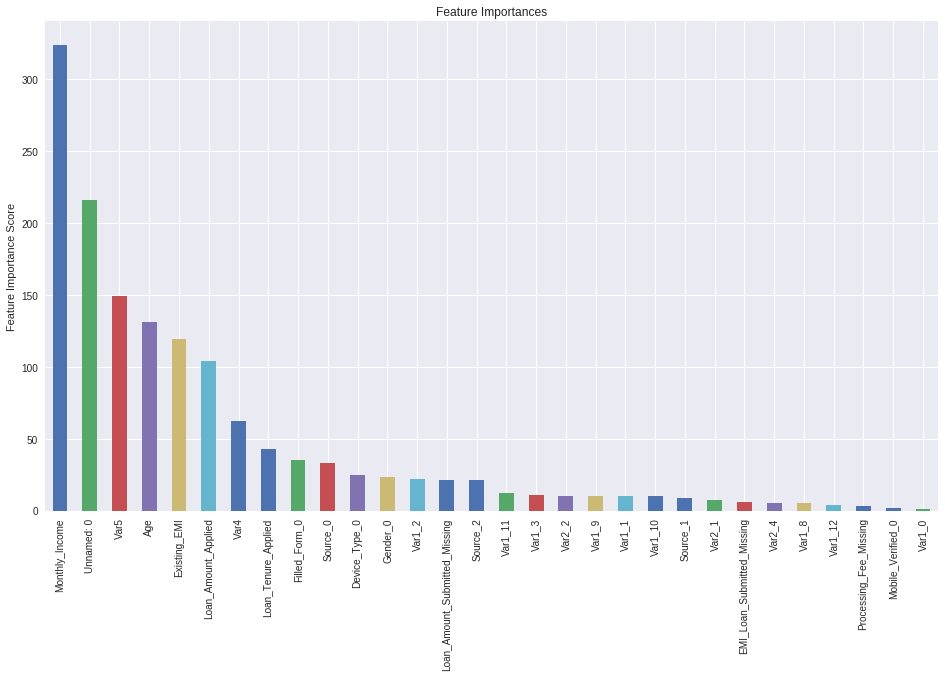

In [29]:
%time

modelfit(xgb3, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [30]:
#Your code here

xgb4 = XGBClassifier(
        learning_rate=xgb3.get_params()['learning_rate']/10,
        n_estimators=xgb3.get_params()['n_estimators']*10,
        max_depth=gsearch2.best_params_['max_depth'],
        min_child_weight=gsearch2b.best_params_['min_child_weight'],
        gamma=gsearch3.best_params_['gamma'],
        subsample=gsearch4b.best_params_['subsample'],
        colsample_bytree=gsearch4b.best_params_['colsample_bytree'],
        reg_alpha=gsearch5b.best_params_['reg_alpha'],
        objective='binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=random_seed)

xgb4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.1, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=7, missing=None,
       n_estimators=1500, n_jobs=1, nthread=-1,
       objective='binary:logistic', random_state=0, reg_alpha=0.01,
       reg_lambda=1, scale_pos_weight=1, seed=199, silent=True,
       subsample=0.9)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs

Model Report
Accuracy : 0.9855
AUC Score (Train): 0.880986
AUC Score (Test): 0.838760


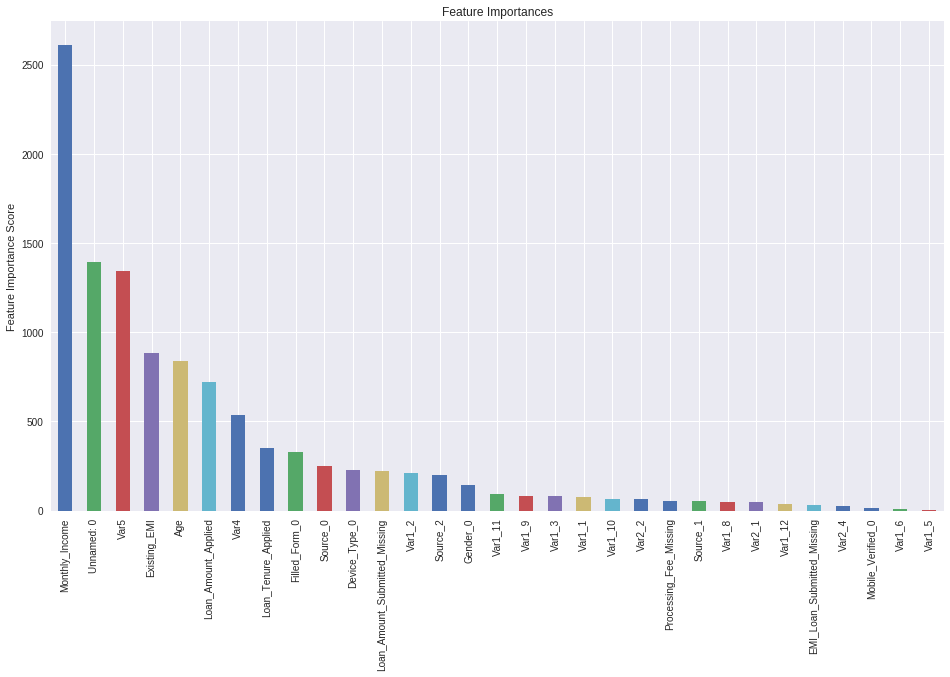

In [32]:
%time

modelfit(xgb4, X_train, X_test, predictors)